In [1]:
%%capture
!pip install datasets
!pip install optuna

In [2]:
# The value for the seed and paths
SEED = 168
PATH_TO_W2V_MODEL_DRIVE = '/content/drive/MyDrive/NLP 24-25 Sem1/GoogleNews-vectors-negative300.bin'
PATH_TO_W2V_MODEL_LOCAL = r'C:/Users/60178/Downloads/GoogleNews-vectors-negative300.bin'
PATH_TO_FASTTEXT_MODEL_DRIVE = '/content/drive/MyDrive/NLP 24-25 Sem1/cc.en.300.bin'
PATH_TO_FASTTEXT_MODEL_LOCAL = r'C:/Users/60178/Downloads/cc.en.300.bin/cc.en.300.bin'

In [3]:
# Standard library imports
from collections import Counter

# General third-party libraries import
import copy
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_model
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import sys

# Import optuna for hyperparams tuning
import optuna

# Import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary nltk resources
nltk.download('wordnet')
nltk.download('punkt')  # Ensure punkt is downloaded for tokenization
nltk.download('stopwords')  # Ensure stopwords are also downloaded if not already

# Import pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.nn.utils.rnn import pad_sequence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\60178\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\60178\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\60178\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Method to set random seed to ensure consistency
def set_seed(seed = SEED):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

# Factory to create the dataloader
def dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device):
    # Create Tensor datasets
    train_dataset = TensorDataset(X_train_sequence.to(device), torch.tensor(Y_train, dtype=torch.long, device=device))
    val_dataset = TensorDataset(X_val_sequence.to(device), torch.tensor(Y_val, dtype=torch.long, device=device))
    test_dataset = TensorDataset(X_test_sequence.to(device), torch.tensor(Y_test, dtype=torch.long, device=device))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > self.max_validation_accuracy:
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        elif validation_accuracy < (self.max_validation_accuracy - self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Factory to provide required optimizer which specified parameters
def optimizer_factory(optimizer_name, model, learning_rate, momentum = 0.8):
    if optimizer_name == 'Adam':
        return torch.optim.Adam(model.parameters(), lr = learning_rate)
    if optimizer_name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
    if optimizer_name == 'RMSprop':
        return torch.optim.RMSprop(model.parameters(), lr = learning_rate)

# Method to train the model
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # Set model to training mode
    train_loss = 0  # To accumulate loss for this epoch

    for inputs, labels in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        # Calculate loss
        loss = loss_fn(outputs.squeeze(), labels.float())  # Squeeze to match dimensions
        loss.backward()  # Backpropagation

        optimizer.step()  # Update parameters

        train_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the epoch
    train_loss /= len(dataloader)
    return train_loss

# Method to evaluate the model
def test_loop(dataloader, model):
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            outputs = model(inputs)  # Forward pass
            predicted = (outputs.squeeze() > 0.5).float()  # Apply threshold

            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()  # Count correct predictions

    accuracy = correct / total
    return accuracy

# Method to plot the performance graph
def plot_performance(train_losses, val_accuracies, num_epochs):
    # Visualization
    plt.figure(figsize=(12, 5))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs + 1, 10))
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, num_epochs + 1, 10))
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Part 0. Dataset Preparation**

Part 0. Dataset Preparation We will be using the movie review dataset introduced in https://www.cs.cornell.edu/people/ pabo/movie-review-data/rt-polaritydata.README.1.0.txt. To load this dataset, you need to install the “datasets” library via pip install datasets. Then you can use the following code snippet: 1 from datasets import load_dataset 2 dataset = load_dataset (" rotten_tomatoes ") 3 train_dataset = dataset [’train ’] 4 validation_dataset = dataset [’validation ’] 5 test_dataset = dataset [’test ’] Using the original train-valid-test split provided in the above code, you will perform model training on the training dataset, configure your model (e.g., learning rate, batch size, number of training epochs) on the validation dataset, and conduct evaluation on the test dataset.

# **Load Dataset**

In [5]:
set_seed()
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [6]:
print(f"train_dataset size: {len(train_dataset)}")
print(f"validation_dataset size: {len(validation_dataset)}")
print(f"test_dataset size: {len(test_dataset)}")
print(f"data format: {train_dataset[0]}")

train_dataset size: 8530
validation_dataset size: 1066
test_dataset size: 1066
data format: {'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


In [7]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"The name of the CUDA device is: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!
The name of the CUDA device is: NVIDIA GeForce RTX 3060 Laptop GPU


# **Load word2vec Model**

In [8]:
# Load the pre-trained Word2Vec model
if 'google.colab' in sys.modules:
    print("Running on Google Colab's hosted runtime")
    from google.colab import drive
    drive.mount('/content/drive')
    w2v_model = KeyedVectors.load_word2vec_format(PATH_TO_W2V_MODEL_DRIVE, binary=True)
else:
    print("Running on a local runtime")
    w2v_model = KeyedVectors.load_word2vec_format(PATH_TO_W2V_MODEL_LOCAL, binary=True)

# Get the dimension of the embeddings
vector_dim = w2v_model.vector_size
print(f"Word2Vec Dimension: {vector_dim}")


Running on a local runtime
Word2Vec Dimension: 300


# **Data Preprocessing**

In [9]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

# Dataset Preprocessing to tokenize and/or lemmatize
def preprocess_dataset(data, lemmatization = True):
    processed_sentences = []

    for entry in data:
        text = entry['text']
        # Tokenize the sentence
        tokens = word_tokenize(text)
        if lemmatization:
          # With case folding, punctuation and stop words removal
          # tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in punctuation and word.lower() not in stop_words]

          # With case folding and punctuation removal
            tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in punctuation]

        processed_sentences.append(tokens)

    return processed_sentences

# Get vocab and oov words
def get_vocab_OOV(sentences, w2v_model):
    vocabulary = set()
    oov_words = set()

    for sentence in sentences:
        for word in sentence:
            vocabulary.add(word)
            if word not in w2v_model:
                oov_words.add(word)

    return vocabulary, oov_words

vocabulary, oov_words = get_vocab_OOV(preprocess_dataset(train_dataset, False), w2v_model)
lemmatized_vocabulary, lemmatized_oov_words = get_vocab_OOV(preprocess_dataset(train_dataset), w2v_model)

print(f"Before lemmatization: Vocabulary size: {len(vocabulary)}, OOV words: {len(oov_words)}")
print(f"After lemmatization: Vocabulary size: {len(lemmatized_vocabulary)}, OOV words: {len(lemmatized_oov_words)}")

Before lemmatization: Vocabulary size: 18030, OOV words: 3613
After lemmatization: Vocabulary size: 16570, OOV words: 3585




1.   Lemmatize, case folding for train, validation and test set
2.   Drop words not found in train dataset for validation and test set




In [10]:
preprocessed_train_dataset = preprocess_dataset(train_dataset)
preprocessed_validation_dataset = preprocess_dataset(validation_dataset)
preprocessed_test_dataset = preprocess_dataset(test_dataset)

In [11]:
def drop_oov(preprocessed_dataset, w2v_model):
    return [[word for word in sentence if word in w2v_model] for sentence in preprocessed_dataset]

def drop_non_train_vocab(dataset, train_vocab):
    return [[word for word in sentence if word in train_vocab] for sentence in dataset]

X_train = drop_oov(preprocessed_train_dataset, w2v_model)
Y_train = [entry['label'] for entry in train_dataset]

X_val = drop_non_train_vocab(drop_oov(preprocessed_validation_dataset, w2v_model), lemmatized_vocabulary)
Y_val = [entry['label'] for entry in validation_dataset]

X_test = drop_non_train_vocab(drop_oov(preprocessed_test_dataset, w2v_model), lemmatized_vocabulary)
Y_test = [entry['label'] for entry in test_dataset]

Sanity check: If preprocessed data is wrong

In [12]:
print(f"X_train size: {len(X_train)}")
print(f"Y_train size: {len(Y_train)}")

print(f"X_val size: {len(X_val)}")
print(f"Y_val size: {len(Y_val)}")

print(f"X_test size: {len(X_test)}")
print(f"Y_test size: {len(Y_test)}")

X_train size: 8530
Y_train size: 8530
X_val size: 1066
Y_val size: 1066
X_test size: 1066
Y_test size: 1066


# **Generate Embedding**

In [13]:
def get_word2index(train_vocab):
    word2index = {}
    for idx, word in enumerate(train_vocab):
        word2index[word] = idx + 1  # +1 to offset 0 for padding
    return word2index

word2index = get_word2index(lemmatized_vocabulary)

In [14]:
print(f"word2index size = vocab size: {len(word2index)}")

word2index size = vocab size: 16570


In [15]:
def create_embedding_matrix(w2v_model, word2index, embedding_dim=300):
    """
    Creates an embedding matrix based on the word2index mapping and Word2Vec model.

    Args:
    - w2v_model: Pre-trained Word2Vec model.
    - word2index: Dictionary mapping words to their indices.
    - embedding_dim: Dimension of the Word2Vec word vectors (default: 300).

    Returns:
    - embedding_matrix: Embedding matrix where each row corresponds to the vector of a word in the vocabulary.
    """
    vocab_size = len(word2index)  # Number of words in the training vocabulary

    # Initialize the embedding matrix with zeros (or any other value)
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
    mean = np.mean(w2v_model.vectors, axis=0)
    std = np.std(w2v_model.vectors, axis=0)

    for word, idx in word2index.items():
        if word in w2v_model:
            # If the word exists in the Word2Vec model, use its pre-trained embedding
            embedding_matrix[idx] = w2v_model[word]
        else:
            # For out-of-vocabulary (OOV) words, initialize a random vector
            #embedding_matrix[idx] = mean
            #embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))
            embedding_matrix[idx] = np.random.normal(
                loc=mean, scale=std, size=(embedding_dim,)
            )

    return embedding_matrix

embedding_dim = w2v_model.vector_size  # Get the dimension of the word vectors in Word2Vec
embedding_matrix = create_embedding_matrix(w2v_model, word2index, embedding_dim)
print(f"embedding_matrix shape: {embedding_matrix.shape}")


embedding_matrix shape: (16571, 300)


# **Sentence2sequence + Padding**

In [16]:
# Get maximum sentence length
def get_max_sentence_length(*datasets):
    """
    Get the maximum sentence length from the provided datasets.

    Args:
    - datasets: A variable number of lists containing tokenized sentences.

    Returns:
    - max_length: The maximum sentence length across all datasets.
    """
    max_length = 0
    for index, dataset in enumerate(datasets):
        # Update max_length if a longer sentence is found
        max_length = max(max_length, max(len(sentence) for sentence in dataset))
        min_length = min(len(sentence) for sentence in dataset)
        print(f"Min sentence length in dataset {index}: {min_length}")
    return max_length

# Example usage
max_length = get_max_sentence_length(X_train, X_val, X_test)
print(f"Maximum sentence length of three datasets: {max_length}")

Min sentence length in dataset 0: 0
Min sentence length in dataset 1: 0
Min sentence length in dataset 2: 1
Maximum sentence length of three datasets: 46


In [17]:
def convert_to_sequence_data(tokenized_data, word2index, max_length=max_length):
    """
    Preprocess the tokenized data for RNN input.

    Args:
    - tokenized_data: List of tokenized sentences.
    - word2index: Dictionary mapping words to indices.
    - max_length: Maximum length for padding (default is 100).

    Returns:
    - padded_sequences: Padded tensor of sequences.
    """
    # Convert tokens to indices
    indexed_sequences = []
    for sentence in tokenized_data:
        indexed_sentence = [word2index.get(word, 0) for word in sentence]  # Use 0 for OOV words

        # Truncate or pad the indexed sentence to the specified max_length
        if len(indexed_sentence) > max_length:
            indexed_sentence = indexed_sentence[:max_length]  # Truncate
        else:
            indexed_sentence += [0] * (max_length - len(indexed_sentence))  # Pad with zeros

        indexed_sequences.append(torch.tensor(indexed_sentence, dtype=torch.long))

    # Convert list of tensors to a padded tensor
    padded_sequences = torch.stack(indexed_sequences)

    return padded_sequences

# Convert to sequence
X_train_sequence = convert_to_sequence_data(X_train, word2index)
X_val_sequence = convert_to_sequence_data(X_val , word2index)
X_test_sequence = convert_to_sequence_data(X_test, word2index)


Sanity check: if the sequenced tokens mapped correctly to embedding matrix and w2v_model

In [18]:
# Check if the sequenced tokens mapped correctly to embedding matrix and w2v_model
embedding_matrix[X_train_sequence[0][0]] == w2v_model[X_train[0][0]]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [19]:
print(f"Shape of X_train_sequence: {X_train_sequence.shape}")
print(f"Shape of X_valn_sequence: {X_val_sequence.shape}")
print(f"Shape of X_test_sequence: {X_test_sequence.shape}")

Shape of X_train_sequence: torch.Size([8530, 46])
Shape of X_valn_sequence: torch.Size([1066, 46])
Shape of X_test_sequence: torch.Size([1066, 46])


# **RNN Model Definition**

In [20]:
class SimpleRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, aggregation='last_hidden_state', freeze_embedding=True):
        super(SimpleRNN, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.aggregation = aggregation

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32, device=device),
            padding_idx = 0,  # We are using 0 for padding index
            freeze = freeze_embedding,  # Freezing the embeddings
        )

        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for binary classification

        if aggregation == 'mhsa':
            self.mhsa = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4, batch_first=True)

    def forward(self, x):
        # Pass through the embedding layer
        embedded = self.embedding(x)

        # Initialize hidden state (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.rnn.num_layers, embedded.size(0), self.rnn.hidden_size).to(embedded.device)

        # Forward pass through RNN
        out, _ = self.rnn(embedded, h0)

        if (self.aggregation == 'last_hidden_state'):
          # Use the last hidden state for the final output
          out = out[:, -1, :]  # Get the output of the last time step
        elif (self.aggregation == 'max_pool'):
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            out = out.masked_fill(~mask, -100000)
            out, _ = torch.max(out, dim=1)
        elif (self.aggregation == 'mean_pool'):
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            out = out * mask
            summed = out.sum(dim=1)
            valid_counts = mask.sum(dim=1)
            valid_counts = valid_counts.clamp(min=1)
            out = summed / valid_counts
        elif self.aggregation == 'mhsa':
            # Create a padding mask where 0 indicates a non-padding token and 1 indicates padding
            # This is a workaround to avoid receiving nan for all padded sentences
            padding_mask_final = torch.zeros(x.size(0), x.size(1), dtype=torch.bool, device=device)
            padding_mask = (x[:, 1:] == self.embedding.padding_idx)
            padding_mask_final[:, 1:] = padding_mask

            # Multi-head self-attention layer
            out, _ = self.mhsa(out, out, out, key_padding_mask=padding_mask_final)

            # Obtain the mean of the weighted output
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            out = out * mask
            summed = out.sum(dim=1)
            valid_counts = mask.sum(dim=1)
            valid_counts = valid_counts.clamp(min=1)
            out = summed / valid_counts

        out = self.dropout(out)  # Apply dropout
        out = self.fc(out)  # Final fully connected layer

        # Sigmoid activation for binary classification
        out = torch.sigmoid(out)

        return out


# **RNN Hyperparameter Tuning (Last Hidden State)**

In [ ]:
'''def rnn_last_hidden_state_objective(trial):
    max_accuracy = 0

    # Hyperparameters

    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])  # Learning rate choices
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices
    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

    # Initialize the model
    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'last_hidden_state')
    model.to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Initialize the early stopper
    early_stopper = EarlyStopper(delta = 0.05)

    # Lists to store loss and accuracy for visualization
    train_losses = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        loss = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(loss)

        # Evaluate on validation set
        val_accuracy = test_loop(val_loader, model)
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_accuracy:
          max_accuracy = val_accuracy

        # Early stopping
        if early_stopper.early_stop(val_accuracy):
           break

    return max_accuracy  # Return validation accuracy for optimization

set_seed() # Reset the seed for reproducibility
study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(rnn_last_hidden_state_objective, n_trials=50)  # Invoke optimization of the objective function.'''

"def rnn_last_hidden_state_objective(trial):\n    max_accuracy = 0\n\n    # Hyperparameters\n\n    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices\n    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices\n    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])  # Learning rate choices\n    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices\n    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices\n    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices\n\n    # Create data loaders\n    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)\n\n    # Initialize the model\n    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'last_hidden_

# **Best Hyperparameter RNN (Last Hidden State)**

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 1  # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'last_hidden_state')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize Early Stopper
early_stopper = EarlyStopper(delta = 0.05)

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.7028, Validation Accuracy: 0.4634
Epoch [2/50], Train Loss: 0.6990, Validation Accuracy: 0.4728
Epoch [3/50], Train Loss: 0.6975, Validation Accuracy: 0.5019
Epoch [4/50], Train Loss: 0.6989, Validation Accuracy: 0.5075
Epoch [5/50], Train Loss: 0.6985, Validation Accuracy: 0.4981
Epoch [6/50], Train Loss: 0.6966, Validation Accuracy: 0.4503
Epoch [7/50], Train Loss: 0.6924, Validation Accuracy: 0.5056
Epoch [8/50], Train Loss: 0.6959, Validation Accuracy: 0.5028
Epoch [9/50], Train Loss: 0.6954, Validation Accuracy: 0.5000
Epoch [10/50], Train Loss: 0.6953, Validation Accuracy: 0.5038
Epoch [11/50], Train Loss: 0.6949, Validation Accuracy: 0.4972
Epoch [12/50], Train Loss: 0.6958, Validation Accuracy: 0.4991
Epoch [13/50], Train Loss: 0.6952, Validation Accuracy: 0.4991
Epoch [14/50], Train Loss: 0.6939, Validation Accuracy: 0.5009
Epoch [15/50], Train Loss: 0.6932, Validation Accuracy: 0.4981
Epoch [16/50], Train Loss: 0.6950, Validation Accuracy: 0.4991
E

C:\Users\60178\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:592: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


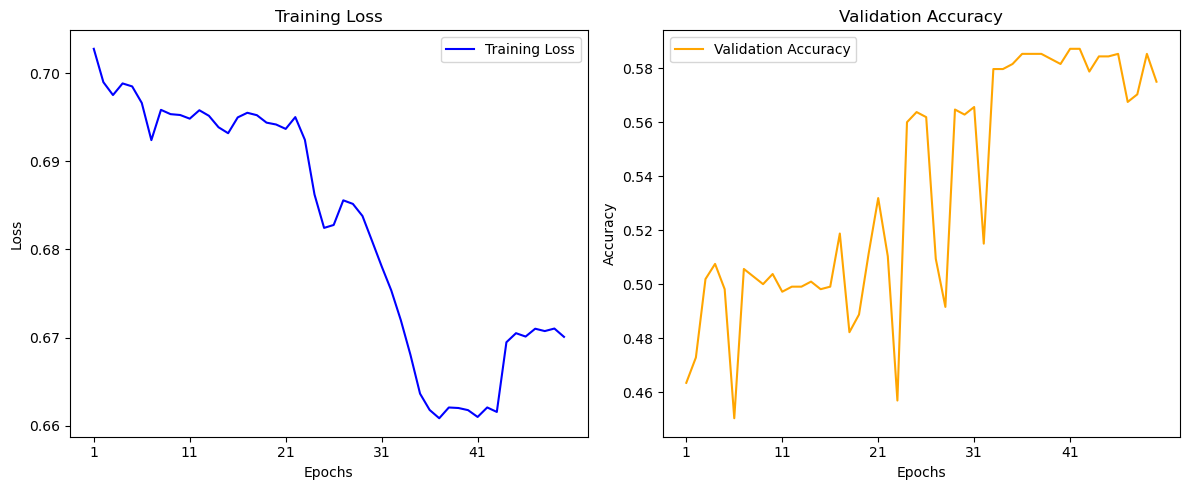

In [ ]:
plot_performance(train_losses, val_accuracies, len(train_losses))

# **RNN Hyperparameter Tuning (Max Pooling)**

In [ ]:
'''def rnn_max_pool_objective(trial):
    max_accuracy = 0

    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices
    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

    # Initialize the model
    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool')
    model.to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Initialize the early stopper
    early_stopper = EarlyStopper()

    # Lists to store loss and accuracy for visualization
    train_losses = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        loss = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(loss)

        # Evaluate on validation set
        val_accuracy = test_loop(val_loader, model)
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_accuracy:
          max_accuracy = val_accuracy

        # Early stopping
        if early_stopper.early_stop(val_accuracy):
           break

    return max_accuracy  # Return validation accuracy for optimization

set_seed() # Reset the seed for reproducibility
study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(rnn_max_pool_objective, n_trials=50)  # Invoke optimization of the objective function.'''

"def rnn_max_pool_objective(trial):\n    max_accuracy = 0\n\n    # Hyperparameters\n    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices\n    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices\n    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices\n    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices\n    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices\n    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices\n\n    # Create data loaders\n    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)\n\n    # Initialize the model\n    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool')\n    model.to(devi

# **Best Hyperparameter RNN (Max Pooling)**

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 2  # Number of RNN layers choices
learning_rate = 0.01  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'SGD'  # Optimizer choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break


# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.7038, Validation Accuracy: 0.5169
Epoch [2/50], Train Loss: 0.6822, Validation Accuracy: 0.5994
Epoch [3/50], Train Loss: 0.6267, Validation Accuracy: 0.6970
Epoch [4/50], Train Loss: 0.5496, Validation Accuracy: 0.7373
Epoch [5/50], Train Loss: 0.5199, Validation Accuracy: 0.7617
Epoch [6/50], Train Loss: 0.5061, Validation Accuracy: 0.7458
Epoch [7/50], Train Loss: 0.4922, Validation Accuracy: 0.7570
Epoch [8/50], Train Loss: 0.4666, Validation Accuracy: 0.7674
Epoch [9/50], Train Loss: 0.4675, Validation Accuracy: 0.7824
Epoch [10/50], Train Loss: 0.4612, Validation Accuracy: 0.7617
Epoch [11/50], Train Loss: 0.4695, Validation Accuracy: 0.7233
Epoch [12/50], Train Loss: 0.4356, Validation Accuracy: 0.7542
Epoch [13/50], Train Loss: 0.4454, Validation Accuracy: 0.7739
Epoch [14/50], Train Loss: 0.4154, Validation Accuracy: 0.7795
Early stopping triggered!
Using Best Model, Test Accuracy: 0.7702


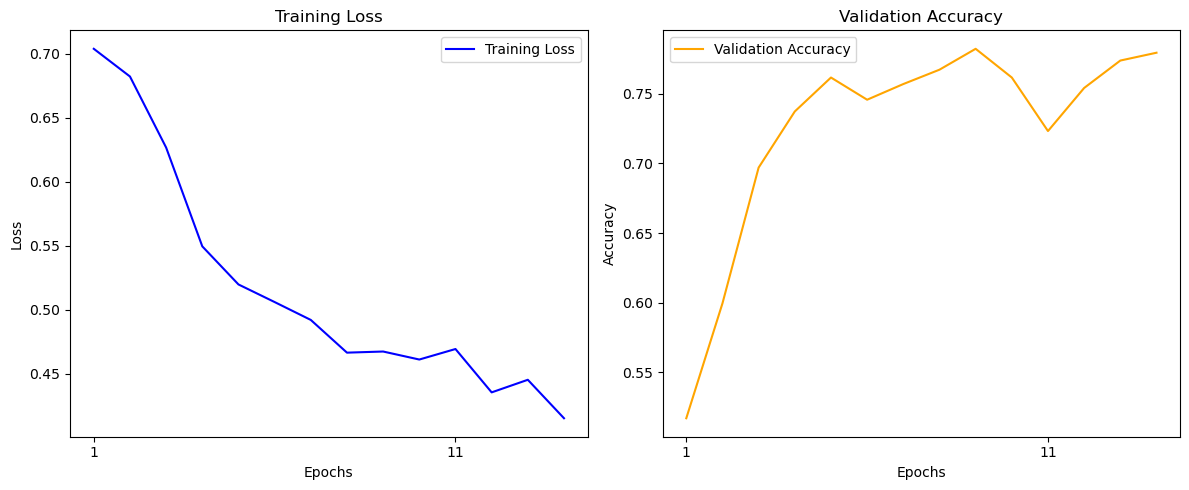

In [ ]:
plot_performance(train_losses, val_accuracies, len(train_losses))

# **RNN Hyperparameter Tuning (Mean Pooling)**

In [ ]:
'''def rnn_mean_pool_objective(trial):
    max_accuracy = 0
    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices
    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

    # Initialize the model
    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'mean_pool')
    model.to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Initialize the early stopper
    early_stopper = EarlyStopper()

    # Lists to store loss and accuracy for visualization
    train_losses = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        loss = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(loss)

        # Evaluate on validation set
        val_accuracy = test_loop(val_loader, model)
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_accuracy:
          max_accuracy = val_accuracy

        # Early stopping
        if early_stopper.early_stop(val_accuracy):
           break

    return max_accuracy  # Return validation accuracy for optimization

set_seed() # Reset the seed for reproducibility
study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(rnn_mean_pool_objective, n_trials=50)  # Invoke optimization of the objective function.'''

"def rnn_mean_pool_objective(trial):\n    max_accuracy = 0\n    # Hyperparameters\n    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices\n    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices\n    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices\n    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices\n    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices\n    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices\n\n    # Create data loaders\n    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)\n\n    # Initialize the model\n    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'mean_pool')\n    model.to(devi

# **Best Hyperparameter RNN (Mean Pooling)**

In [ ]:
# The Best Hyperparameters
hidden_size = 64  # Hidden size choices
num_layers = 1  # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.5472, Validation Accuracy: 0.7242
Epoch [2/50], Train Loss: 0.4932, Validation Accuracy: 0.7326
Epoch [3/50], Train Loss: 0.4748, Validation Accuracy: 0.7505
Epoch [4/50], Train Loss: 0.4717, Validation Accuracy: 0.7598
Epoch [5/50], Train Loss: 0.4638, Validation Accuracy: 0.7430
Epoch [6/50], Train Loss: 0.4608, Validation Accuracy: 0.7176
Epoch [7/50], Train Loss: 0.4549, Validation Accuracy: 0.7627
Epoch [8/50], Train Loss: 0.4473, Validation Accuracy: 0.7439
Epoch [9/50], Train Loss: 0.4428, Validation Accuracy: 0.7749
Epoch [10/50], Train Loss: 0.4333, Validation Accuracy: 0.7402
Epoch [11/50], Train Loss: 0.4294, Validation Accuracy: 0.7570
Epoch [12/50], Train Loss: 0.4220, Validation Accuracy: 0.7692
Epoch [13/50], Train Loss: 0.4127, Validation Accuracy: 0.7561
Epoch [14/50], Train Loss: 0.4056, Validation Accuracy: 0.7645
Early stopping triggered!
Using Best Model, Test Accuracy: 0.7664


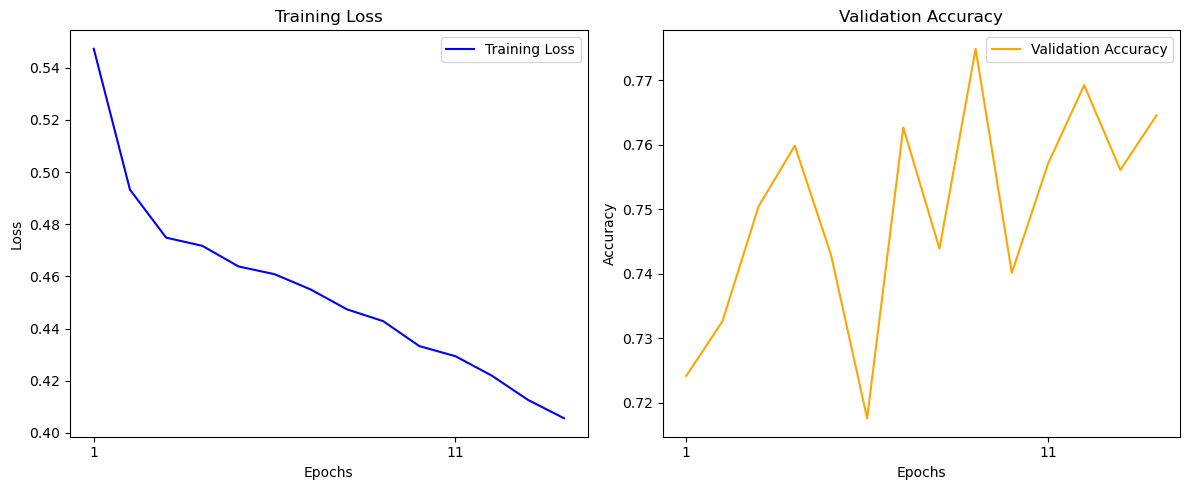

In [ ]:
plot_performance(train_losses, val_accuracies, len(train_losses))

# **RNN Hyperparameter Tuning (MHSA - Mean)**

In [ ]:
'''def rnn_mhsa_mean_objective(trial):
    max_accuracy = 0

    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices
    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

    # Initialize the model
    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'mhsa')
    model.to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Initialize the early stopper
    early_stopper = EarlyStopper()

    # Lists to store loss and accuracy for visualization
    train_losses = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        loss = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(loss)

        # Evaluate on validation set
        val_accuracy = test_loop(val_loader, model)
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_accuracy:
          max_accuracy = val_accuracy

        # Early stopping
        if early_stopper.early_stop(val_accuracy):
           break

    return max_accuracy  # Return validation accuracy for optimization

set_seed() # Reset the seed for reproducibility
study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(rnn_max_pool_objective, n_trials=50)  # Invoke optimization of the objective function.'''

"def rnn_mhsa_mean_objective(trial):\n    max_accuracy = 0\n\n    # Hyperparameters\n    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices\n    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices\n    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices\n    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices\n    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices\n    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices\n\n    # Create data loaders\n    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)\n\n    # Initialize the model\n    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'mhsa')\n    model.to(device)

# **Best Hyperparameter RNN (MHSA - Mean)**

In [ ]:
# The Best Hyperparameters
hidden_size = 256  # Hidden size choices
num_layers = 1  # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'Adam'  # Optimizer choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'mhsa')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break


# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.5285, Validation Accuracy: 0.7589
Epoch [2/50], Train Loss: 0.4584, Validation Accuracy: 0.7730
Epoch [3/50], Train Loss: 0.4272, Validation Accuracy: 0.7655
Epoch [4/50], Train Loss: 0.4044, Validation Accuracy: 0.7814
Epoch [5/50], Train Loss: 0.3884, Validation Accuracy: 0.7523
Epoch [6/50], Train Loss: 0.3695, Validation Accuracy: 0.7814
Epoch [7/50], Train Loss: 0.3445, Validation Accuracy: 0.7523
Epoch [8/50], Train Loss: 0.3325, Validation Accuracy: 0.7627
Epoch [9/50], Train Loss: 0.3127, Validation Accuracy: 0.7542
Epoch [10/50], Train Loss: 0.2991, Validation Accuracy: 0.7636
Early stopping triggered!
Using Best Model, Test Accuracy: 0.7842


# **Part 3**

# **RNN Hyperparameter Tuning (Max Pooling, Unfreeze Embedding)**

In [29]:
'''def rnn_q3_1_objective(trial):
    max_accuracy = 0
    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])  # Hidden size choices
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices
    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

    # Initialize the model
    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool', False)
    model.to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Initialize the early stopper
    early_stopper = EarlyStopper()

    # Lists to store loss and accuracy for visualization
    train_losses = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        loss = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(loss)

        # Evaluate on validation set
        val_accuracy = test_loop(val_loader, model)
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_accuracy:
          max_accuracy = val_accuracy

        # Early stopping
        if early_stopper.early_stop(val_accuracy):
           break

    return max_accuracy  # Return validation accuracy for optimization

set_seed() # Reset the seed for reproducibility
study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(rnn_q3_1_objective, n_trials=40)  # Invoke optimization of the objective function.'''

"def rnn_q3_1_objective(trial):\n    max_accuracy = 0\n    # Hyperparameters\n    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])  # Hidden size choices\n    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices\n    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices\n    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices\n    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices\n    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices\n\n    # Create data loaders\n    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)\n\n    # Initialize the model\n    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool', False)\n    model.to(de

# **Best Hyperparameter RNN (Max Pooling, Unfreeze Embedding)**

In [27]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 1  # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices

In [28]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool', False)
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.5316, Validation Accuracy: 0.7814
Epoch [2/50], Train Loss: 0.3265, Validation Accuracy: 0.7889
Epoch [3/50], Train Loss: 0.2101, Validation Accuracy: 0.7336
Epoch [4/50], Train Loss: 0.1141, Validation Accuracy: 0.7795
Epoch [5/50], Train Loss: 0.0858, Validation Accuracy: 0.7627
Epoch [6/50], Train Loss: 0.0476, Validation Accuracy: 0.7627
Epoch [7/50], Train Loss: 0.0322, Validation Accuracy: 0.7505
Early stopping triggered!
Using Best Model, Test Accuracy: 0.7889


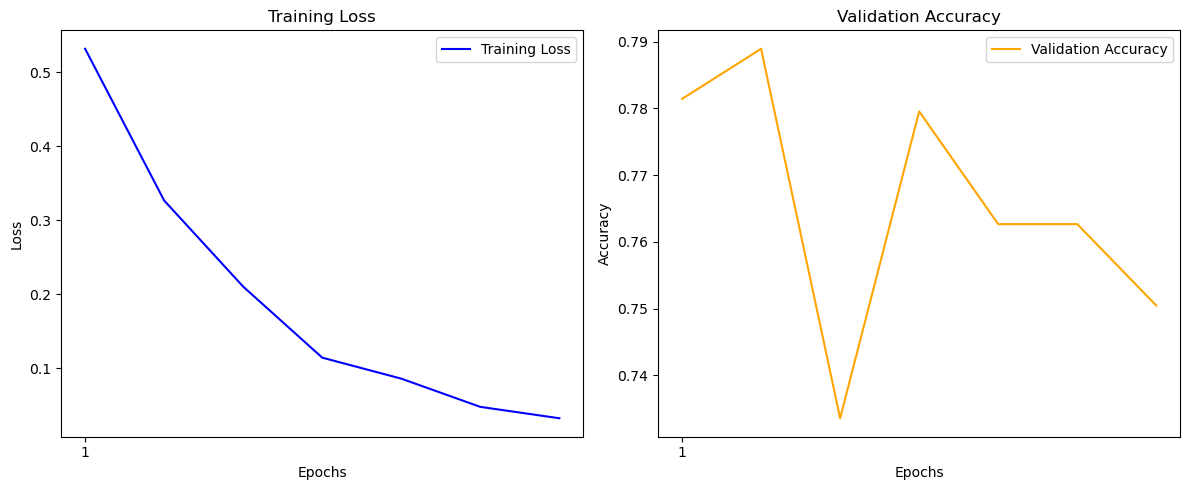

In [30]:
plot_performance(train_losses, val_accuracies, len(train_losses))

# **Handling OOV**

## **Load FastText Model**

In [ ]:
# Load the pre-trained Word2Vec model
'''if 'google.colab' in sys.modules:
    print("Running on Google Colab's hosted runtime")
    from google.colab import drive
    drive.mount('/content/drive')
    fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_DRIVE)
else:
    print("Running on a local runtime")
    fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_LOCAL)

# Get the dimension of the embeddings
fasttext_vector_dim = fasttext_model.vector_size
print(f"FastText Dimension: {fasttext_vector_dim}")

def create_fasttext_embedding_matrix(fasttext_model, word2index, embedding_dim=300):
    vocab_size = len(word2index)  # Number of words in the training vocabulary

    # Initialize the embedding matrix with zeros (or any other value)
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

    for word, idx in word2index.items():
        embedding_matrix[idx] = fasttext_model.wv[word]

    return embedding_matrix
'''

'if \'google.colab\' in sys.modules:\n    print("Running on Google Colab\'s hosted runtime")\n    from google.colab import drive\n    drive.mount(\'/content/drive\')\n    fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_DRIVE)\nelse:\n    print("Running on a local runtime")\n    fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_LOCAL)\n\n# Get the dimension of the embeddings\nfasttext_vector_dim = fasttext_model.vector_size\nprint(f"FastText Dimension: {fasttext_vector_dim}")\n\ndef create_fasttext_embedding_matrix(fasttext_model, word2index, embedding_dim=300):\n    vocab_size = len(word2index)  # Number of words in the training vocabulary\n\n    # Initialize the embedding matrix with zeros (or any other value)\n    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))\n\n    for word, idx in word2index.items():\n        embedding_matrix[idx] = fasttext_model.wv[word]\n\n    return embedding_matrix\n'

## **Preprocessing**

In [ ]:
X_train_OOV = preprocessed_train_dataset
Y_train_OOV = [entry['label'] for entry in train_dataset]

X_val_OOV = drop_non_train_vocab(preprocessed_validation_dataset, lemmatized_vocabulary)
Y_val_OOV = [entry['label'] for entry in validation_dataset]

X_test_OOV = drop_non_train_vocab(preprocessed_test_dataset, lemmatized_vocabulary)
Y_test_OOV = [entry['label'] for entry in test_dataset]

## **Seq2Seq + Padding**

In [ ]:
max_length_with_oov = get_max_sentence_length(X_train_OOV, X_val_OOV, X_test_OOV)
print(f"Maximum sentence length of three datasets: {max_length_with_oov}")

X_train_OOV_sequence = convert_to_sequence_data(X_train_OOV, word2index, max_length_with_oov)
X_val_OOV_sequence = convert_to_sequence_data(X_val_OOV , word2index, max_length_with_oov)
X_test_OOV_sequence = convert_to_sequence_data(X_test_OOV, word2index, max_length_with_oov)

print(f"Shape of X_train_OOV_sequence: {X_train_OOV_sequence.shape}")
print(f"Shape of X_val_OOV_sequence: {X_val_OOV_sequence.shape}")
print(f"Shape of X_test_OOV_sequence: {X_test_OOV_sequence.shape}")

Min sentence length in dataset 0: 1
Min sentence length in dataset 1: 0
Min sentence length in dataset 2: 1
Maximum sentence length of three datasets: 53
Shape of X_train_OOV_sequence: torch.Size([8530, 53])
Shape of X_val_OOV_sequence: torch.Size([1066, 53])
Shape of X_test_OOV_sequence: torch.Size([1066, 53])


## **Training**

### **Tuning**

In [ ]:
'''def rnn_q3_2_objective(trial):
    max_accuracy = 0
    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])  # Hidden size choices
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices
    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_OOV_sequence, X_val_OOV_sequence, X_test_OOV_sequence, Y_train_OOV, Y_val_OOV, Y_test_OOV, batch_size, device)

    # Initialize the model
    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool', False)
    model.to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Initialize the early stopper
    early_stopper = EarlyStopper()

    # Lists to store loss and accuracy for visualization
    train_losses = []
    val_accuracies = []

    # Training Loop
    for epoch in range(num_epochs):
        loss = train_loop(train_loader, model, criterion, optimizer)
        train_losses.append(loss)

        # Evaluate on validation set
        val_accuracy = test_loop(val_loader, model)
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_accuracy:
          max_accuracy = val_accuracy

        # Early stopping
        if early_stopper.early_stop(val_accuracy):
           break

    return max_accuracy  # Return validation accuracy for optimization

set_seed() # Reset the seed for reproducibility
study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(rnn_q3_2_objective, n_trials=40)  # Invoke optimization of the objective function.'''

"def rnn_q3_2_objective(trial):\n    max_accuracy = 0\n    # Hyperparameters\n    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])  # Hidden size choices\n    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices\n    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])  # Learning rate choices\n    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices\n    num_epochs = trial.suggest_categorical('num_epochs', [30, 50])  # num epoch choices\n    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices\n\n    # Create data loaders\n    train_loader, val_loader, test_loader = dataloader_factory(X_train_OOV_sequence, X_val_OOV_sequence, X_test_OOV_sequence, Y_train_OOV, Y_val_OOV, Y_test_OOV, batch_size, device)\n\n    # Initialize the model\n    model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool',

### **Best RNN**

In [ ]:
# The Best Hyperparameters
hidden_size = 256  # Hidden size choices
num_layers = 2  # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 30  # num epoch choices
optimizer_name = 'Adam'  # Optimizer choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_OOV_sequence, X_val_OOV_sequence, X_test_OOV_sequence, Y_train_OOV, Y_val_OOV, Y_test_OOV, batch_size, device)

# Initialize the model
model = SimpleRNN(embedding_matrix, hidden_size, num_layers, 'max_pool', False)
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/30], Train Loss: 0.5137, Validation Accuracy: 0.7852
Epoch [2/30], Train Loss: 0.3229, Validation Accuracy: 0.7749
Epoch [3/30], Train Loss: 0.1904, Validation Accuracy: 0.7674
Epoch [4/30], Train Loss: 0.1015, Validation Accuracy: 0.7655
Epoch [5/30], Train Loss: 0.0559, Validation Accuracy: 0.7589
Epoch [6/30], Train Loss: 0.0368, Validation Accuracy: 0.7486
Early stopping triggered!
Using Best Model, Test Accuracy: 0.8021


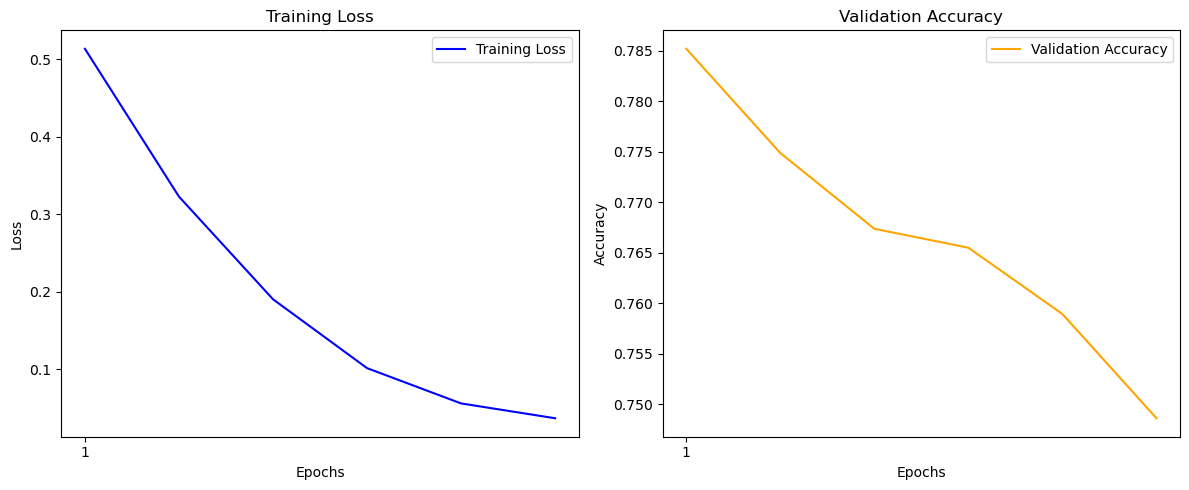

In [ ]:
plot_performance(train_losses, val_accuracies, len(train_losses))